In [1]:
def to_grayscale(img_rgb):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    return gray[..., None]  # (H, W, 1)

In [2]:
def gaussian_noise(img, sigma_range=(0.01, 0.08)):
    sigma = np.random.uniform(*sigma_range)
    noise = np.random.normal(0, sigma, img.shape)
    return img + noise

In [3]:
def salt_pepper_noise(img, prob_range=(0.001, 0.01)):
    p = np.random.uniform(*prob_range)
    mask = np.random.rand(*img.shape) < p
    img[mask] = np.random.choice([0.0, 1.0])
    return img

In [4]:
def multiplicative_noise(img, sigma_range=(0.02, 0.06)):
    sigma = np.random.uniform(*sigma_range)
    noise = np.random.normal(0, sigma, img.shape)
    return img * (1 + noise)

In [5]:
def correlated_noise(img, sigma=0.05):
    noise = np.random.normal(0, sigma, img.shape)
    noise = cv2.GaussianBlur(noise, (5, 5), 0)
    return img + noise

In [6]:
def structured_noise(img, max_lines=5):
    # Ensure the image is single channel for line drawing, as intended for grayscale.
    if img.ndim == 3 and img.shape[2] > 1:
        # Convert to grayscale by taking the mean along the channel axis
        # This handles cases where img might have unexpectedly become multi-channel
        img = img.mean(axis=-1, keepdims=True)
    elif img.ndim == 2: # If it's a 2D grayscale image, add a channel dimension
        img = img[..., None]

    h, w, _ = img.shape # Now img should definitely be (H, W, 1)

    for _ in range(np.random.randint(1, max_lines)):
        x = np.random.randint(0, w)
        thickness = np.random.randint(1, 5)
        cv2.line(img, (x, 0), (x, h),
                 color=np.random.uniform(0.1, 0.4), # Scalar color for 1-channel image
                 thickness=thickness)

    return img

In [7]:
def random_blur(img):
    if np.random.rand() < 0.5:
        k = np.random.choice([3, 5, 7])
        img = cv2.GaussianBlur(img, (k, k), 0)
    return img

In [8]:
import random

def degrade_image(img_gray):
    img = img_gray.copy()

    noise_functions = [
        (gaussian_noise, 0.5),
        (salt_pepper_noise, 0.3),
        (multiplicative_noise, 0.5),
        (correlated_noise, 0.5),
        (structured_noise, 0.2)
    ]

    random.shuffle(noise_functions)

    for noise_fn, prob in noise_functions:
        if random.random() < prob:
            img = noise_fn(img)

    img = random_blur(img)

    return np.clip(img, 0.0, 1.0)


In [9]:
def jpeg_compression(img, quality_range=(20, 90)):
    """
    Simule la compression JPEG sur une image normalisée [0,1].
    quality_range : intervalle de qualité JPEG (plus bas = plus dégradé)
    """
    import cv2
    import numpy as np

    # convertir en uint8
    img_uint8 = (img * 255).astype(np.uint8)

    # tirer la qualité aléatoire
    quality = np.random.randint(*quality_range)

    # encoder en JPEG en mémoire
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    result, encimg = cv2.imencode('.jpg', img_uint8, encode_param)

    # décoder pour récupérer l'image
    img_jpeg = cv2.imdecode(encimg, cv2.IMREAD_UNCHANGED)

    # remettre dans [0,1] float32
    img_jpeg = img_jpeg.astype(np.float32) / 255.0

    # si l'image était grayscale avec 1 canal, on garde le canal
    if img_jpeg.ndim == 2:
        img_jpeg = img_jpeg[..., None]

    return img_jpeg


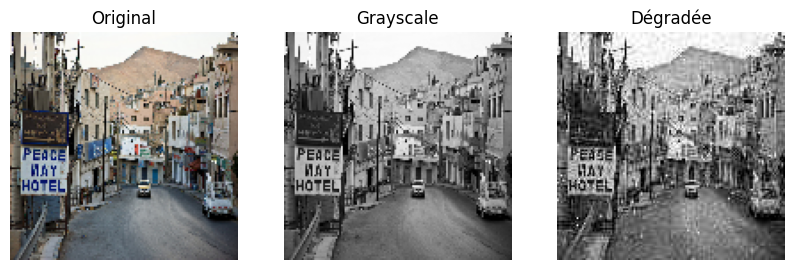

In [ ]:
import matplotlib.pyplot as plt
import numpy as np # Added for np.float32 and general numpy operations
import random # Added for random.choice and random.random
import cv2
import matplotlib.pyplot as plt
import os

import random

#tester image de la deuxieme list / deuxieme dataset
img_path = "../data/test.jpg"


#tester image de la deuxieme list / deuxieme dataset

#img_name = random.choice(image_ids)
#img_path = os.path.join(img_root, img_name)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128, 128))
img = img.astype(np.float32) / 255.0

gray = to_grayscale(img)
degraded = degrade_image(gray)

# Fix: If degraded has an unexpected number of channels (like 128),
# take the mean across the channel dimension to make it 2D for grayscale display.
# Otherwise, just squeeze it as intended.
if degraded.ndim == 3 and degraded.shape[2] > 4: # Check for unexpected multi-channel output
    degraded_for_display = degraded.mean(axis=-1)
else:
    degraded_for_display = degraded.squeeze()
jpeg_compressiong = jpeg_compression(degraded_for_display)

#on save l'iamge dégradée
cv2.imwrite("../data/degraded_image.jpg", (jpeg_compressiong * 255).astype(np.uint8))


plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.title("Original"); plt.imshow(img); plt.axis("off")
plt.subplot(1,3,2); plt.title("Grayscale"); plt.imshow(gray.squeeze(), cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title("Dégradée"); plt.imshow(jpeg_compressiong, cmap="gray"); plt.axis("off")
plt.show()